##Configuration de l’environnement Spark

In [1]:
from pyspark.sql import SparkSession



In [2]:
spark = SparkSession.builder \
    .appName("Prediction") \
    .getOrCreate()


In [3]:
print(spark)


In [4]:
path = r"C:\Users\aamir\Desktop\YC\P\ChurnPrediction\src\infrastructure\data\dataset-68f599a4c9b84581895311-6907667a3f0be705109390.csv"

data = spark.read.csv(path, header=True, inferSchema=True)

data.printSchema()


root
 |-- RowNumber: integer (nullable = true)
 |-- CustomerId: integer (nullable = true)
 |-- Surname: string (nullable = true)
 |-- CreditScore: integer (nullable = true)
 |-- Geography: string (nullable = true)
 |-- Gender: string (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Tenure: integer (nullable = true)
 |-- Balance: double (nullable = true)
 |-- NumOfProducts: integer (nullable = true)
 |-- HasCrCard: integer (nullable = true)
 |-- IsActiveMember: integer (nullable = true)
 |-- EstimatedSalary: double (nullable = true)
 |-- Exited: integer (nullable = true)



In [5]:
data.show()

+---------+----------+---------+-----------+---------+------+---+------+---------+-------------+---------+--------------+---------------+------+
|RowNumber|CustomerId|  Surname|CreditScore|Geography|Gender|Age|Tenure|  Balance|NumOfProducts|HasCrCard|IsActiveMember|EstimatedSalary|Exited|
+---------+----------+---------+-----------+---------+------+---+------+---------+-------------+---------+--------------+---------------+------+
|        1|  15634602| Hargrave|        619|   France|Female| 42|     2|      0.0|            1|        1|             1|      101348.88|     1|
|        2|  15647311|     Hill|        608|    Spain|Female| 41|     1| 83807.86|            1|        0|             1|      112542.58|     0|
|        3|  15619304|     Onio|        502|   France|Female| 42|     8| 159660.8|            3|        1|             0|      113931.57|     1|
|        4|  15701354|     Boni|        699|   France|Female| 39|     1|      0.0|            2|        0|             0|       93

In [6]:
num_columns =["RowNumber","CustomerId","CreditScore","Age","Tenure","Exited","EstimatedSalary","IsActiveMember","HasCrCard","NumOfProducts","Balance"];
obj_columns = ["Gender", "Geography", "Surname"]

data.select(obj_columns).describe().show()


+-------+------+---------+-------+
|summary|Gender|Geography|Surname|
+-------+------+---------+-------+
|  count| 10000|    10000|  10000|
|   mean|  NULL|     NULL|   NULL|
| stddev|  NULL|     NULL|   NULL|
|    min|Female|   France|  Abazu|
|    max|  Male|    Spain| Zuyeva|
+-------+------+---------+-------+



In [7]:
data.select(num_columns).describe().show()

+-------+------------------+-----------------+-----------------+------------------+------------------+-------------------+-----------------+-------------------+-------------------+------------------+-----------------+
|summary|         RowNumber|       CustomerId|      CreditScore|               Age|            Tenure|             Exited|  EstimatedSalary|     IsActiveMember|          HasCrCard|     NumOfProducts|          Balance|
+-------+------------------+-----------------+-----------------+------------------+------------------+-------------------+-----------------+-------------------+-------------------+------------------+-----------------+
|  count|             10000|            10000|            10000|             10000|             10000|              10000|            10000|              10000|              10000|             10000|            10000|
|   mean|            5000.5|  1.56909405694E7|         650.5288|           38.9218|            5.0128|             0.2037|100090

In [8]:
from pyspark.sql.functions import col, count, when, trim, isnan
from pyspark.sql.types import FloatType, DoubleType, DecimalType

null_counts = []
for c in data.columns:
    dtype = next(f.dataType for f in data.schema.fields if f.name == c)

    if isinstance(dtype, (FloatType, DoubleType, DecimalType)):
        cond = col(c).isNull() | isnan(col(c))
    else:
        cond = col(c).isNull() | (trim(col(c)) == "")
        
    null_counts.append(count(when(cond, c)).alias(c))

nulldata = data.select(null_counts)
nulldata.show()

+---------+----------+-------+-----------+---------+------+---+------+-------+-------------+---------+--------------+---------------+------+
|RowNumber|CustomerId|Surname|CreditScore|Geography|Gender|Age|Tenure|Balance|NumOfProducts|HasCrCard|IsActiveMember|EstimatedSalary|Exited|
+---------+----------+-------+-----------+---------+------+---+------+-------+-------------+---------+--------------+---------------+------+
|        0|         0|      0|          0|        0|     0|  0|     0|      0|            0|        0|             0|              0|     0|
+---------+----------+-------+-----------+---------+------+---+------+-------+-------------+---------+--------------+---------------+------+



In [9]:
from pyspark.sql import functions as F

data.groupBy("Geography").agg(  F.avg("CreditScore").alias("Moyenne_CreditScore"),
    F.avg("Age").alias("Moyenne_Age"),
    F.sum("Exited").alias("Nb_quitte")
).show()


+---------+-------------------+------------------+---------+
|Geography|Moyenne_CreditScore|       Moyenne_Age|Nb_quitte|
+---------+-------------------+------------------+---------+
|  Germany|  651.4535671582304|39.771622160223195|      814|
|   France|  649.6683286796969| 38.51176705225369|      810|
|    Spain|  651.3338716188938| 38.89099717400081|      413|
+---------+-------------------+------------------+---------+



In [10]:
data.columns

['RowNumber',
 'CustomerId',
 'Surname',
 'CreditScore',
 'Geography',
 'Gender',
 'Age',
 'Tenure',
 'Balance',
 'NumOfProducts',
 'HasCrCard',
 'IsActiveMember',
 'EstimatedSalary',
 'Exited']

In [11]:
data.createOrReplaceTempView("clients")

spark.sql("""
    SELECT Geography, Gender,
           COUNT(*) AS Total,
           AVG(CreditScore) AS Moy_Credit,
           AVG(Exited) AS Taux_Churn
    FROM clients
    GROUP BY Geography, Gender
    ORDER BY Taux_Churn DESC
""").show()


+---------+------+-----+-----------------+-------------------+
|Geography|Gender|Total|       Moy_Credit|         Taux_Churn|
+---------+------+-----+-----------------+-------------------+
|  Germany|Female| 1193|653.0938809723386| 0.3755238893545683|
|  Germany|  Male| 1316|649.9665653495441|0.27811550151975684|
|    Spain|Female| 1089|651.7695133149679|0.21212121212121213|
|   France|Female| 2261|649.1857585139319| 0.2034498009730208|
|    Spain|  Male| 1388|650.9920749279539|0.13112391930835735|
|   France|  Male| 2753|650.0646567381038|0.12713403559752998|
+---------+------+-----+-----------------+-------------------+



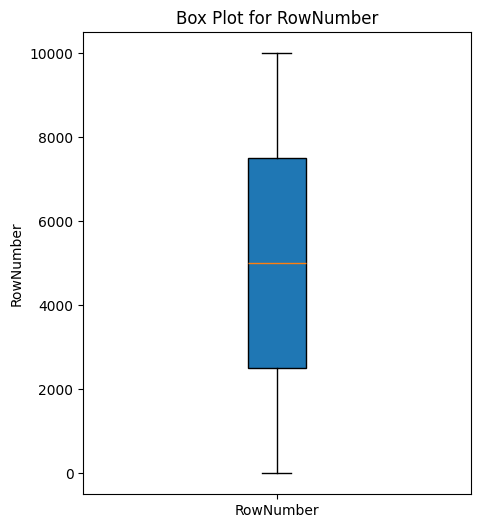

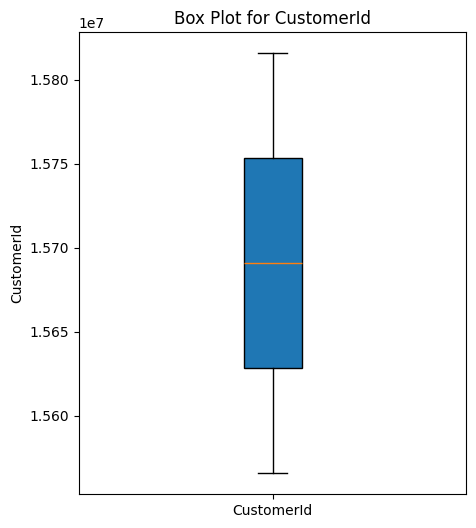

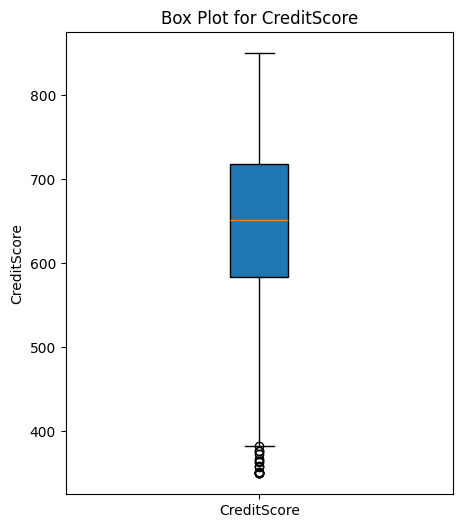

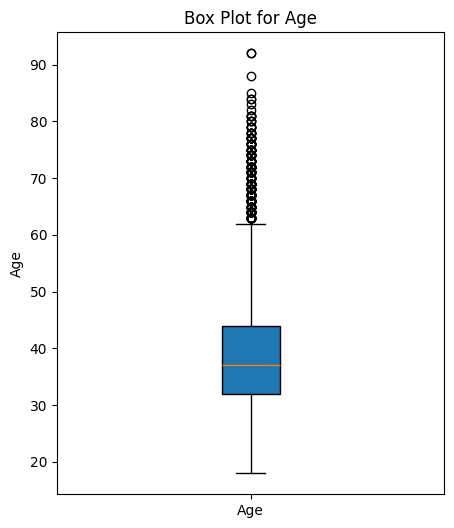

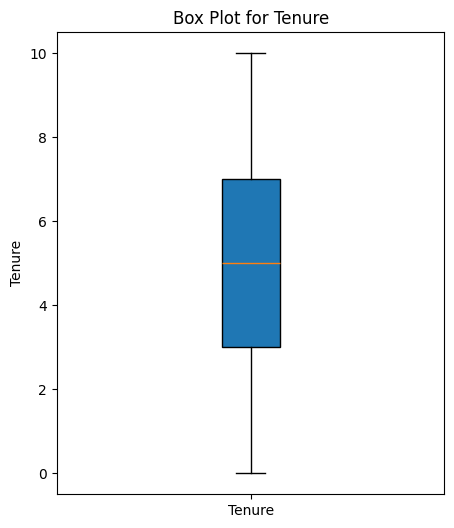

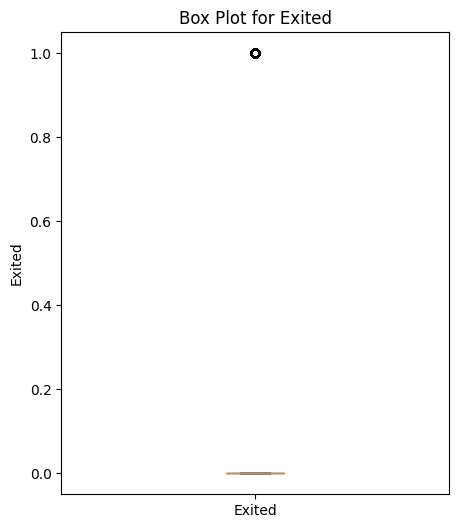

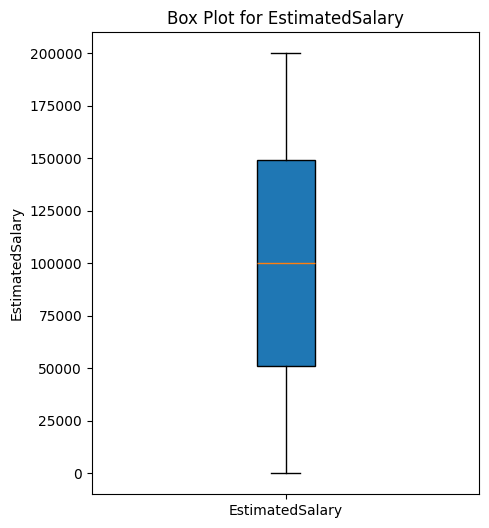

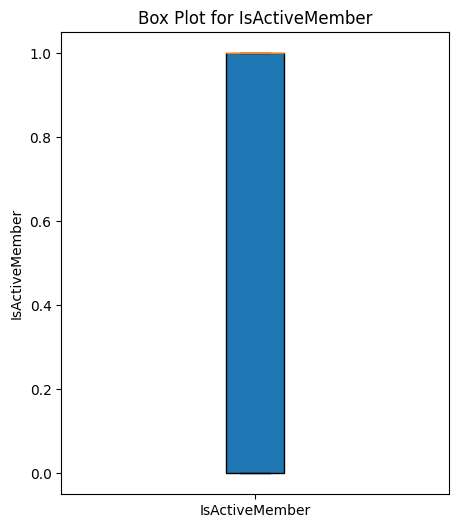

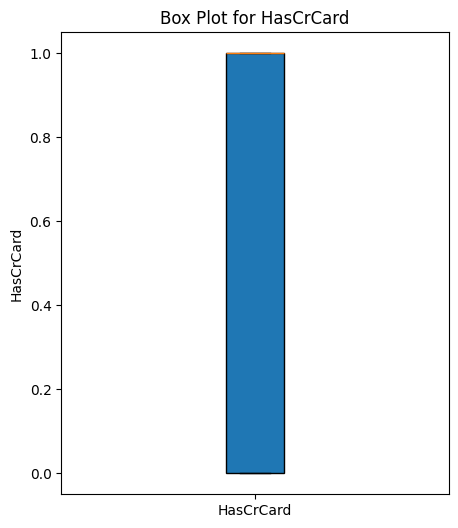

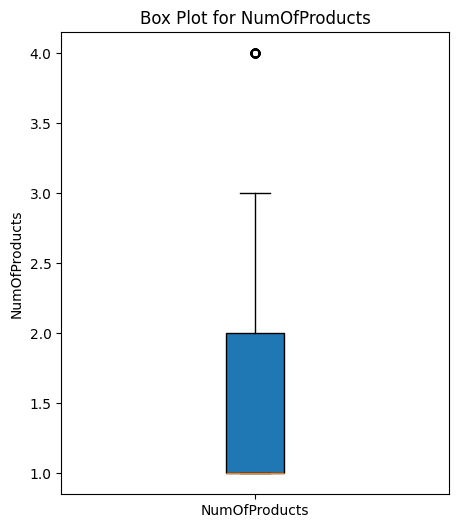

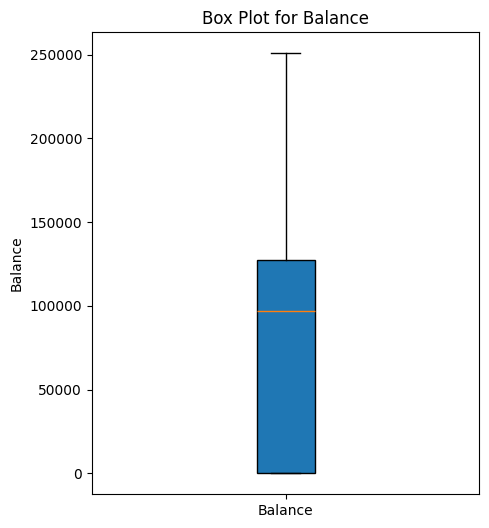

In [12]:
import pandas as pd

import matplotlib.pyplot as plt

for col in num_columns: 
    pdf = data.select(col).toPandas()
    
    plt.figure(figsize=(5, 6))
    plt.boxplot(pdf[col], vert=True, patch_artist=True)
    plt.title(f"Box Plot for {col}")
    plt.ylabel(col)
    plt.xticks([1], [col])
    plt.show()

In [13]:
	
from pyspark.sql.functions import col

outlier_counts = {} 
numbers_columns = ["CreditScore","Age","Balance","EstimatedSalary"]


for j in numbers_columns:
    q1,q3 = data.approxQuantile(j,[0.25,0.75],0.01)
    
    IQR = q3 - q1
    
    lower = q1-1.5*IQR
    upper = q3+1.5*IQR

    count_outliers = data.filter((col(j) < lower) | (col(j) > upper)).count()
    outlier_counts[j] = count_outliers
    
for col_name, count in outlier_counts.items():
    print(f"Colonne '{col_name}' : {count} outliers")

Colonne 'CreditScore' : 17 outliers
Colonne 'Age' : 359 outliers
Colonne 'Balance' : 0 outliers
Colonne 'EstimatedSalary' : 0 outliers


In [14]:
data.dtypes

[('RowNumber', 'int'),
 ('CustomerId', 'int'),
 ('Surname', 'string'),
 ('CreditScore', 'int'),
 ('Geography', 'string'),
 ('Gender', 'string'),
 ('Age', 'int'),
 ('Tenure', 'int'),
 ('Balance', 'double'),
 ('NumOfProducts', 'int'),
 ('HasCrCard', 'int'),
 ('IsActiveMember', 'int'),
 ('EstimatedSalary', 'double'),
 ('Exited', 'int')]

In [15]:
plt.figure(figsize=(6, 4))
plt.hist(pdf["Age"].dropna(), bins=30, color='skyblue', edgecolor='black')
plt.title("Histogram of Age")
plt.xlabel("Age")
plt.ylabel("Frequency")
plt.grid(axis='y', alpha=0.6)
plt.tight_layout()
plt.show()


KeyError: 'Age'

<Figure size 600x400 with 0 Axes>